In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, \
                            confusion_matrix, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

from joblib import dump

In [2]:
def classification_summary(model, name, data_label, labels, 
                           X_train, X_test, y_train, y_test, save_path):
    """
    wykonuje uczenie modelu klasyfikacji, drukuje podsumowanie i zwraca metryki wymagane w dalszej analizie
    """
    
    model.fit(X_train, y_train)
    dump(model, f'../../data/04_models/classification/{name} - {data_label}.joblib')
    
    print(f'\nModel: {name}\nDane: {data_label}')
    y_pred = model.predict(X_test).astype(int)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    print(classification_report(y_test, y_pred, target_names=labels))
    return y_pred, cm

In [3]:
def compare_confusion_matrices(x_num, y_num, model_list, X_test, y_test, names, 
                               model_name, data_labels, save_path, size_x=20, size_y=20):
    """
    generuje graficzne przedstawienie macierzy koincydencji dla podanych wersji modelu klasyfikacji
    
    Parameters
    ----------
    x_num : int
        ilośc wierszy w siatce wykresów
    y_num : int
        ilość kolumn w siatce wykresów
    model_list : list
        lista modeli klasyfikacji do generowania macierzy
    X_test : numpy.array
        macierz danych testowych, na których sprawdza się poprawność modelu uczenia maszynowego
    y_test : numpy.array
        wektor poprawnych odpowiedzi, które powinien przewidzieć model uczenia maszynowego
    names : list
        lista klas w modelu klasyfikacji odpowiadających macierzom koincydencji
    model_name : str
        nazwa modelu, dla którego generowane są macierze
    data_labels : list
        lista podtytułów dla poszczególnych macierzy - zawiera informacje o sposobie przygotowania danych
    save_path : str
        ścieżka, pod którą zostanie zapisany wygenerowany wykres (zawierający nazwę pliku wraz z rozszerzeniem)
    size_x : int, optional
        szerokość wykresu
    size_y : int, optional
        wysokość wykresu
    """
    
    fig = plt.figure(figsize=(size_x, size_y))
    fig.subplots_adjust(hspace=0.10, wspace=0.25)
    for model, data_label, i in zip(model_list, data_labels, range(1, x_num*y_num+1)):
        ax = fig.add_subplot(x_num, y_num, i)
        plot_confusion_matrix(model, X_test, y_test, 
                          normalize='true', 
                          display_labels=names,
                          cmap=plt.cm.Blues, 
                          ax=ax)
        ax.set_xlabel('Wartość przewidywana', fontsize=15)
        ax.set_ylabel('Wartość rzeczywista', fontsize=15)
        ax.set_title(f'{model_name}\n{data_label}', fontsize=12)
    plt.savefig(save_path)
    plt.show()

In [4]:
def compare_classification_models(confusion_matrices, model_names, group_names, 
                                  save_path, size_x=20, size_y=10):
    """
    generuje wykres słupkowy porównujący podane jako argument macierze koincydencji
    
    Parameters
    ----------
    confusion_matrices : list
        lista macierzy koincydencji do porównania
    model_names : list
        lista nazw modeli odpowiadających macierzom koincydencji
    group_names : list
        lista klas w modelu klasyfikacji odpowiadających macierzom koincydencji
    save_path : str
        ścieżka, pod którą zostanie zapisany wygenerowany wykres (zawierający nazwę pliku wraz z rozszerzeniem)
    size_x : int, optional
        szerokość wykresu
    size_y : int, optional
        wysokość wykresu
    """
    
    diagonal_values = []
    for matrix in confusion_matrices:
        diagonal_per_matrix = []
        for i in range(len(matrix)):
            diagonal_per_matrix.append(matrix[i][i])
        diagonal_values.append(diagonal_per_matrix[:])
    
    barDim = 0.25
    
    r = []
    r.append(np.arange(len(diagonal_values[0])))
    for i in range(1, len(diagonal_values)):
        r.append([x + barDim for x in r[i-1]])
    
    plt.figure(figsize=(size_x, size_y))
    
    for r_, values, model in zip(r, diagonal_values, model_names):
        plt.bar(r_, values, width=barDim, edgecolor='white', label=model)
    
    plt.xlabel("Klasa klasyfikacji", fontsize=15)
    plt.xticks([r_ + barDim for r_ in range(len(diagonal_values[0]))], group_names)
    
    plt.title('Porównanie skuteczności modeli klasyfikacji\n' + 
              'dla poszczególnych klas',
              fontsize=20)
    plt.legend(fontsize=12)
    plt.savefig(save_path)
    plt.show()

In [5]:
data = pd.read_pickle("../../data/03_training_set/training_set.pkl")

bins = (-np.inf, 0, 15, 50, 100, np.inf)
group_names = ['1.brak', '2.[1-15)', '3.[15-50)', '4.[50-100)', '5.[100+]']
data['new_watchers'] = pd.cut(data['new_watchers'], bins=bins, labels=group_names)

labels = LabelEncoder()
data['new_watchers'] = labels.fit_transform(data['new_watchers'])

X = data.drop(['new_watchers'], axis=1)
y = data['new_watchers']

s = StandardScaler()
X = s.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
X_trains = []
y_trains = []
data_labels = []

In [7]:
X_trains.append(X_train)
y_trains.append(y_train)
data_labels.append('brak usprawnień')

In [8]:
oversample = SMOTE(random_state=42)
X_train_oversample, y_train_oversample = \
    oversample.fit_resample(X_train, y_train)

X_trains.append(X_train_oversample)
y_trains.append(y_train_oversample)
data_labels.append('oversampling')

In [9]:
undersample = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = \
    undersample.fit_resample(X_train, y_train)

X_trains.append(X_train_undersample)
y_trains.append(y_train_undersample)
data_labels.append('undersampling')

In [10]:
n_samples = y_train.value_counts().nlargest(2).iloc[1] * 10

oversample = SMOTE(sampling_strategy={
                        1: n_samples,
                        2: n_samples,
                        3: n_samples,
                        4: n_samples,
                    }, random_state=42)
X_train_mix, y_train_mix = \
        oversample.fit_resample(X_train, y_train)

undersample = RandomUnderSampler(random_state=42)
X_train_mix, y_train_mix = \
    undersample.fit_resample(X_train_mix, y_train_mix)

X_trains.append(X_train_mix)
y_trains.append(y_train_mix)
data_labels.append('kombinacja')

In [11]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [12]:
models = [
    [ 
        DecisionTreeClassifier(random_state=42),
        DecisionTreeClassifier(random_state=42),
        DecisionTreeClassifier(random_state=42),
        DecisionTreeClassifier(random_state=42),
    ],
    [
        RandomForestClassifier(n_jobs=6, random_state=42),
        RandomForestClassifier(n_jobs=6, random_state=42),
        RandomForestClassifier(n_jobs=6, random_state=42),
        RandomForestClassifier(n_jobs=6, random_state=42),
    ],
    [
        HistGradientBoostingClassifier(max_depth=4, random_state=42),
        HistGradientBoostingClassifier(max_depth=4, random_state=42),
        HistGradientBoostingClassifier(max_depth=4, random_state=42),
        HistGradientBoostingClassifier(max_depth=4, random_state=42),
    ]
]

In [13]:
names = [
    'Drzewo decyzyjne',
    'Las losowy',
    'Wzmocnienie gradientowe',
]

In [14]:
y_preds = []
confusion_matrices = []

In [15]:
for model_list, name in zip(models, names):
    y_pred_list = []
    confusion_matrice_list = []
    for model, x, y, data_label in zip(model_list, X_trains, y_trains, data_labels):
        y_pred, cm = \
            classification_summary(model, name, data_label, group_names, 
                x, X_test, y, y_test,
                f'../../results/classification/{name} {data_label} - macierz.jpg')
        y_pred_list.append(y_pred)
        confusion_matrice_list.append(cm)
    y_preds.append(y_pred_list[:])
    confusion_matrices.append(confusion_matrice_list[:])


Model: Drzewo decyzyjne
Dane: brak usprawnień
              precision    recall  f1-score   support

      1.brak       1.00      1.00      1.00    361543
    2.[1-15)       0.78      0.77      0.78       133
   3.[15-50)       0.77      0.74      0.75       204
  4.[50-100)       0.59      0.66      0.62       119
    5.[100+]       0.78      0.68      0.73       122

    accuracy                           1.00    362121
   macro avg       0.78      0.77      0.78    362121
weighted avg       1.00      1.00      1.00    362121


Model: Drzewo decyzyjne
Dane: oversampling
              precision    recall  f1-score   support

      1.brak       1.00      1.00      1.00    361543
    2.[1-15)       0.80      0.70      0.75       133
   3.[15-50)       0.72      0.77      0.75       204
  4.[50-100)       0.59      0.65      0.62       119
    5.[100+]       0.16      0.67      0.26       122

    accuracy                           1.00    362121
   macro avg       0.66      0.76      0

In [16]:
best_models_confusion_matrices = []

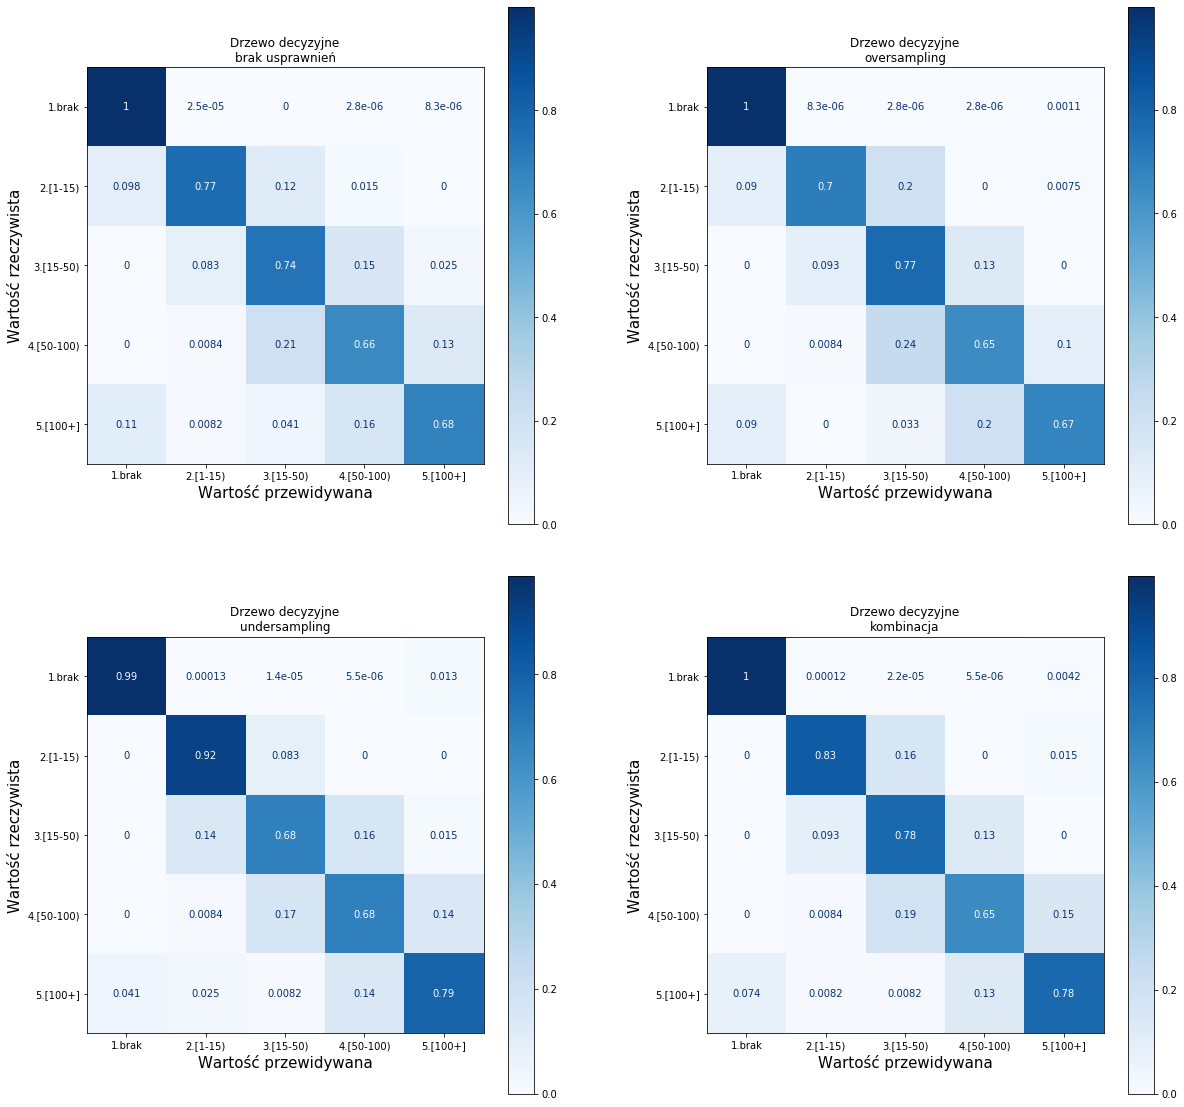

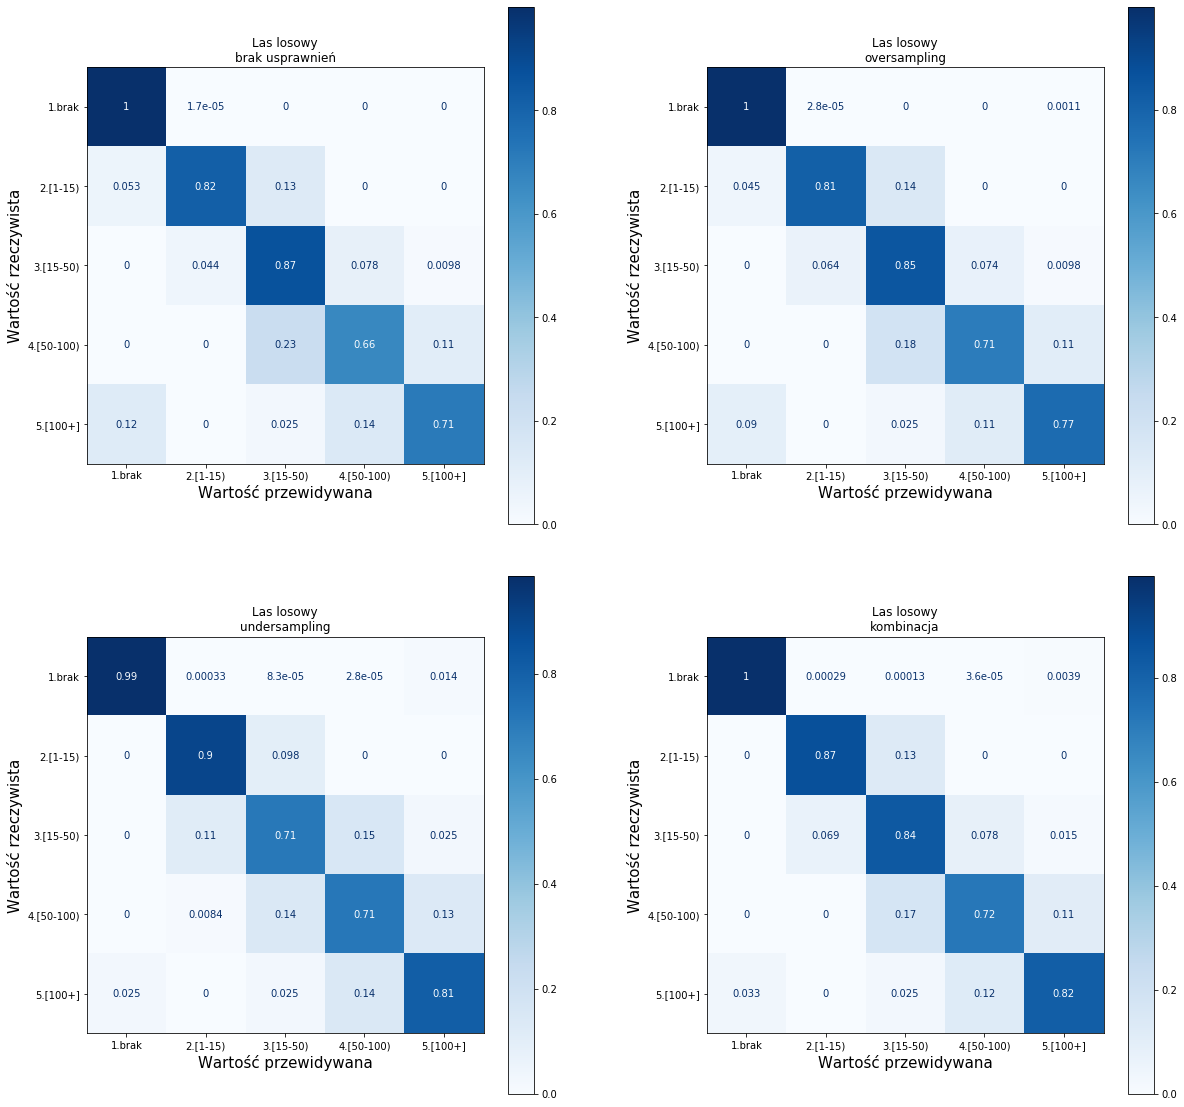

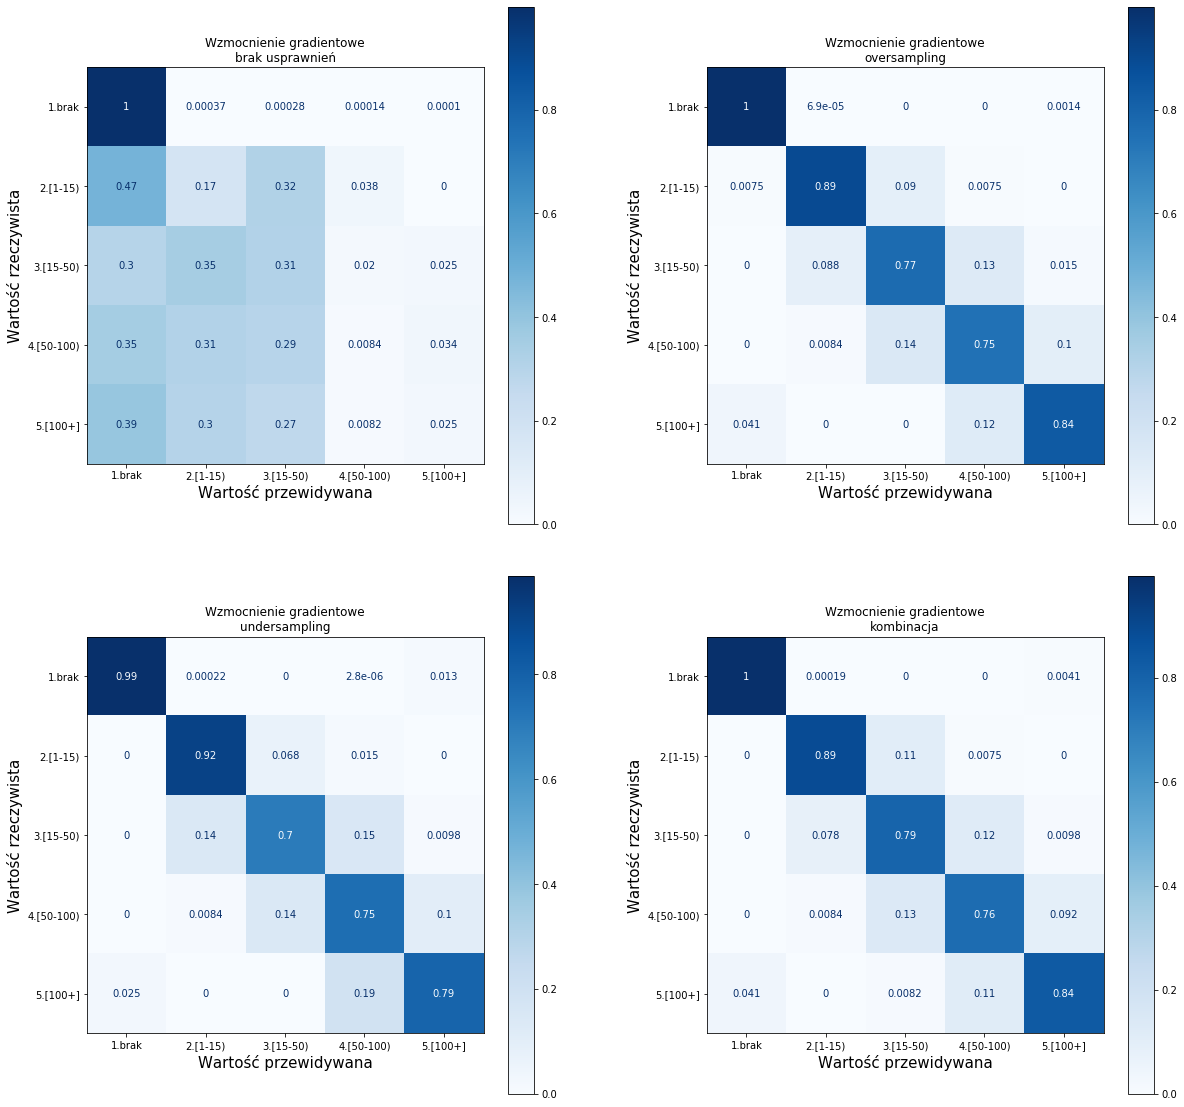

In [18]:
for model_list, name, confusion_matrices_list in zip(models, names, confusion_matrices):

    compare_confusion_matrices(2, 2, model_list, X_test, y_test, 
                                group_names, name, data_labels,
                                f'../../results/classification/macierze koincydencji - {name}.png')
    # najlepszy jest zawsze z over + under
    best_models_confusion_matrices.append(confusion_matrices_list[len(confusion_matrices_list)-1])

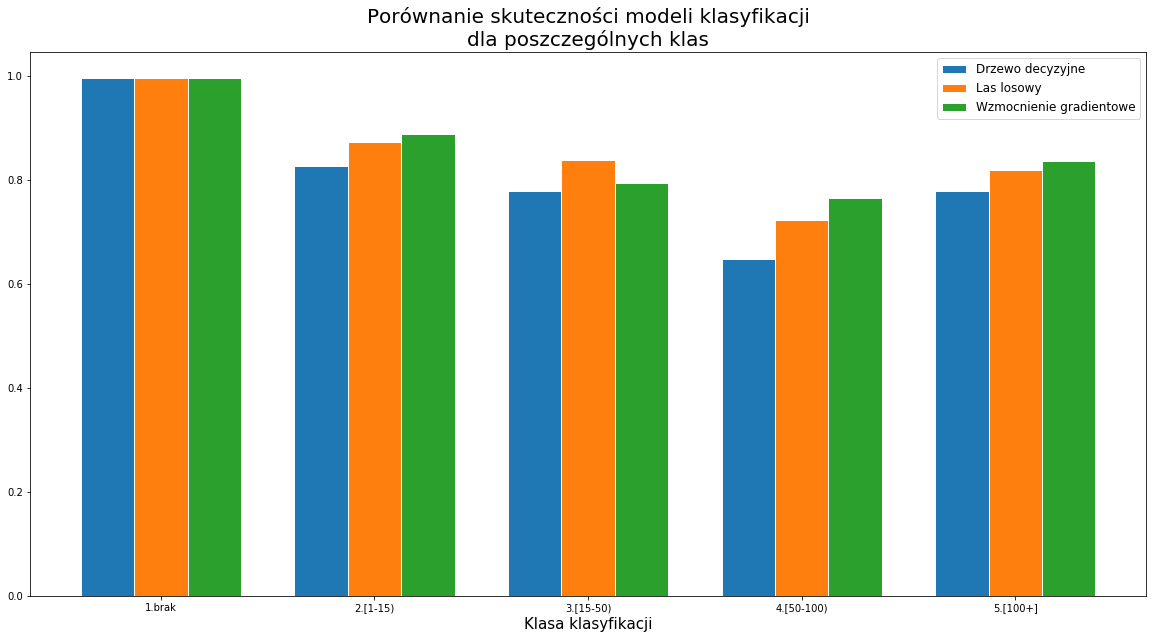

In [19]:
compare_classification_models(best_models_confusion_matrices, names, group_names, 
                              '../../results/classification/porównanie skuteczności modeli klasyfikacji.png')